In [1]:
import numpy as np

In [2]:
F_info=np.load("learned_ndv_estimator/model_training/training_data/rfs_F_infos.npy")

In [3]:
f_s=np.load("learned_ndv_estimator/model_training/training_data/rfs_f_s.npy",allow_pickle=True)

In [4]:
import numpy as np
from numpy.polynomial import Chebyshev
from numpy.polynomial import Hermite
from scipy import optimize
from scipy.special import comb
from estndv import ndvEstimator

In [5]:
import pandas as pd
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib import style
#plt.rcParams['font.sans-serif']=['simhei']
matplotlib.rcParams['text.usetex'] = True
from collections import Counter
import scipy

In [6]:
# Estimator
def Chao(fi):
    if fi.shape[0]==1:
        return sum(fi[:,1])
    if fi[0,0]==1 and fi[1,0]==2:
        return sum(fi[:,1])+fi[0,1]*(fi[0,1]-1)/2/(fi[1,1]+1)
    else:
        return sum(fi[:,1])
def GEE(fi,q):
    import math
    if fi[0,0]==1:
        return sum(fi[:,1])+math.sqrt(1/q)*fi[0,1]
    else:
        return sum(fi[:,1])
def Cheby4f0(fi,pmin=10**(-5)):
    L=int(0.45*np.log(1/pmin))
    ratio=0.5*np.log(1/pmin)
    num = sum(fi[:,0]*fi[:,1])
    def shift_polynomial(coeffs, shift):
        length = len(coeffs)
        coeffs_shift = np.zeros(length)
        for i in range(length):
            for j in range(i+1):
                coeffs_shift[j] += coeffs[i] * (shift**(i-j)) * scipy.special.binom(i, j)
        return coeffs_shift
    if pmin<ratio/num:
        cheb = np.polynomial.chebyshev.Chebyshev.basis(L)
        cheb_coeffs = np.polynomial.chebyshev.cheb2poly(cheb.coef)
        shift = (ratio+num*pmin)/(ratio-num*pmin)
        a_coeffs = shift_polynomial(cheb_coeffs, -shift)
        g_coeffs = -a_coeffs / a_coeffs[0]
        g_coeffs[0] = 0
        scaling = 2. / (ratio-num*pmin)
        for j in range(1, L+1):
            for i in range(1, j+1):
                g_coeffs[j] *= (i*scaling)
            g_coeffs[j]+=1
        esti=0
        for [i,j] in fi:
            if i > L:
                esti+=j
            else:
                esti+=g_coeffs[i]*j
        if esti<sum(fi[:,1]):
            esti=sum(fi[:,1])
    else:
        esti=sum(fi[:,1])
    return esti
def GT(fi):
    t=0.1
    return sum(fi[:,1])+ sum((-1)**(fi[:,0]+1)*t**fi[:,0]*fi[:,1])
    
def Shlosser(fi,q):
    Ef=0
    Exf=0
    if fi[0,0]==1:
        for item in fi:
            Ef+=(1-q)**item[0]*item[1]
            Exf+=q*item[0]*(1-q)**(item[0]-1)*item[1]
        if Exf==0 or fi[0,1]==0:
            return sum(fi[:,1])
        else:
            return sum(fi[:,1])+Ef/Exf*fi[0,1]
    else:
        return sum(fi[:,1])

In [7]:
# Our Model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter
from scipy.special import comb
from scipy import interpolate
import scipy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PolyNet(nn.Module):
    def __init__(self,L=7,H=200):
        super(PolyNet,self).__init__()
        self.L = L
        self.H = H
        self.weight = Parameter(torch.Tensor(self.H))
        self.weight.requires_grad = True
        self.fc1 = nn.Linear(self.L*10, self.L*10//2)
        self.fc2 = nn.Linear(self.L*10//2, self.L)
        self.fc3 = nn.Linear(self.L, self.L)
        self.fc1.requires_grad = True
        self.fc2.requires_grad = True
        self.fc3.requires_grad = True
        self.i = torch.Tensor( [ i+1 for i in range(self.H) ] ).float().to(device)
    def set_paras(self):
        self.weight.data = torch.Tensor([1.0 for i in range(self.H)])
    def forward(self,fi,M_tensor,N,n):
        bt_temp= F.relu(self.fc1( fi) )
        bt=self.fc2(bt_temp)
        f0_loss = torch.einsum('ij,ijk->ik', bt,M_tensor)
        f0_loss=((1.0-f0_loss)*self.weight/self.weight.sum()).sum(1)
        f0 =    torch.relu(  (bt*fi[:,0:self.L]).sum(1) )
        return f0,f0_loss
pnet = PolyNet().to(device)
pnet.set_paras()
for param in pnet.parameters():
    param.data = param.data.to(device)

optimizer = torch.optim.Adam(pnet.parameters(),lr=0.001)

# data prepare

fea = torch.tensor([[0.0 for j in range(70)]  for i in range(f_s.shape[0])]).to(device)
entropy_plus=[]
for i in range(f_s.shape[0]):
    f_s_n=sum(f_s[i][:,0]*f_s[i][:,1])
    entropy_p=0.0
    for item in f_s[i]:
        if item[0]>70:
            entropy_p+= item[1]*item[0]/f_s_n*np.log(f_s_n/item[0])
        else:
            fea[i][item[0]-1]=item[1]
    entropy_plus.append(entropy_p)
entropy_plus = torch.Tensor(entropy_plus).to(device)

d = torch.tensor([ sum(f[:,1]) for f in f_s]).to(device)
n = torch.tensor([ sum(f[:,0]*f[:,1]) for f in f_s] ).to(device)
N = torch.tensor(F_info[:,0]).to(device)

#Entropy = torch.tensor( F_info[:,2]).to(device)
import time
begin1=time.time()
M_tensor=[]
size = F_info.shape[0]
L=7
H=200
data_n=np.array([sum(te[:,1]) for te in f_s])
data_N=F_info[:,0]
for s in range(size):
    M=[]
    for t in range(1,L+1):
        M_temp=[]
        for j in range(1,H+1):
            M_temp.append( comb(data_n[s],t)*(j/(data_N[s]-j))**t)
        M.append(M_temp)
    M=np.array(M)
    M[M<0.001]=0
    M_tensor.append(M)    
M_tensor = torch.tensor(M_tensor).float().to(device)
begin=time.time()
print("prepare time", begin-begin1)
def lossfun(y,y_pred,d,n,N,l0_loss):
    l_log_unreduced = torch.square( torch.log( (y_pred+d)/(y+d)))
    l_bound = torch.sqrt(( (1 / (n.true_divide(N) + 1e-10) - 1) / 2 * 0.2554128 + d) / (d + 1e-6))
    l_log_bound = torch.square(torch.log(l_bound))
    l = torch.mean(torch.abs(l_log_unreduced - l_log_bound) + l_log_bound + 5*torch.log(l0_loss.abs()+1))  
    return torch.log(l)

batch_size=200
train_loss=[]
for i in range(600):
    print("epoch",i)
    for epoch in range(200):
        predict,l0_loss=pnet(
            fea[epoch*batch_size:((epoch+1)*batch_size)] , 
            M_tensor[epoch*batch_size:((epoch+1)*batch_size)],
            N[epoch*batch_size:((epoch+1)*batch_size)],
            n[epoch*batch_size:((epoch+1)*batch_size)])
        #print("finish predict")
        y=torch.tensor(F_info[:,1]).to(device)-d
        loss=lossfun(y[epoch*batch_size:((epoch+1)*batch_size)],predict,
                     d[epoch*batch_size:((epoch+1)*batch_size)],
                     #torch.tensor(F_info[epoch*batch_size:((epoch+1)*batch_size),1]),
                     n[epoch*batch_size:((epoch+1)*batch_size)],
                     torch.tensor(F_info[epoch*batch_size:((epoch+1)*batch_size),0]).to(device),
                     l0_loss)
        #print(sum(l0_loss))
        loss.requires_grad_(True)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss.append(loss)
end=time.time()
print("training time",end-begin)

/home/jiajun_li/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:84: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)


prepare time 416.5573604106903
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
epoch 50
epoch 51
epoch 52
epoch 53
epoch 54
epoch 55
epoch 56
epoch 57
epoch 58
epoch 59
epoch 60
epoch 61
epoch 62
epoch 63
epoch 64
epoch 65
epoch 66
epoch 67
epoch 68
epoch 69
epoch 70
epoch 71
epoch 72
epoch 73
epoch 74
epoch 75
epoch 76
epoch 77
epoch 78
epoch 79
epoch 80
epoch 81
epoch 82
epoch 83
epoch 84
epoch 85
epoch 86
epoch 87
epoch 88
epoch 89
epoch 90
epoch 91
epoch 92
epoch 93
epoch 94
epoch 95
epoch 96
epoch 97
epoch 98
epoch 99
epoch 100
epoch 101
epoch 102
epoch 103
epoch 104
epoch 105
epoch 106
epoch 107

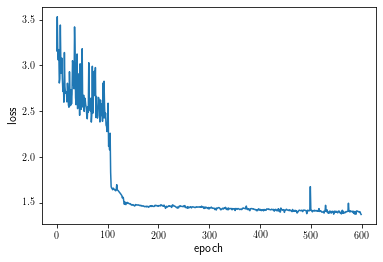

In [8]:
plt.plot(train_loss)
plt.xlabel(r'epoch',fontdict={'size':12},y=0.1)
plt.ylabel(r'loss',fontdict={'size':12})
plt.savefig("loss.pdf",bbox_inches='tight')

In [9]:
def Fi2fi(Fi,q):
    fs = []
    for item in Fi:
        f_i=np.random.binomial(item[0],q,size=item[1])
        fs.append(f_i)
    fs = np.concatenate(fs)
    fs = fs[fs>0]
    unique, counts = np.unique(fs,return_counts=True)
    f_sparse = np.array([unique,counts]).T
    return f_sparse
renEsti=ndvEstimator("learned_ndv_estimator/model_training/model_paras.npy")
import os
Dir="kasandr"
q=0.01
kasResult=[]
order_D = []
for filename in os.listdir(Dir):
    pathname=os.path.join(Dir,filename)
    Fi=np.loadtxt(pathname,delimiter=",",dtype=int)
    if len(Fi.shape)==1:
        Fi=np.array([Fi])
    r1=[]
    r2=[]
    r3=[]
    r4=[]
    r5=[]
    r6=[]
    r7=[]
    r8=[]
    r9=[]
    order_D.append(sum(Fi[:,1]))
    for r in range(5):
        fii=Fi2fi(Fi,q)
        fi_temp=fii
        max_i=max(max(fi_temp[:,0]),L)
        fi_dict={ item[0]:item[1] for item in fi_temp }
        fi=[]
        n=0
        for i in range(1,max_i+1):
            if i in fi_dict.keys():
                fi.append([i,fi_dict[i]])
                n+=i*fi_dict[i]
            else:
                fi.append([i,0])
        fi=np.array(fi)
        
        N=sum(Fi[:,0]*Fi[:,1])
        D=sum(Fi[:,1])
        r1.append( max(GEE(fi,q)/D,D/GEE(fi,q)))
        r2.append( max(Chao(fi)/D,D/ Chao(fi) ) )
        r3.append( max(Cheby4f0(fi,1/N)/D,D/Cheby4f0(fi,1/N) ))
        r4.append( max(GT(fi)/D,D/GT(fi)))
        r5.append( max( Shlosser(fi,q)/D,D/Shlosser(fi,q)) )

        L=7
        H=200
        data_n=n
        data_N=N
        M=[]
        for t in range(1,L+1):
            M_temp=[]
            for j in range(1,H+1):
                M_temp.append( comb(n,t)*(j/(N-j))**t)
            M.append(M_temp)
        M=np.array(M)
        M[M<0.001]=0
        feat=[0.0 for i in range(70)]
        for item in fii:
            if item[0]>70:
                continue
            else:
                feat[item[0]-1]=item[1]
        temp=pnet(torch.tensor([feat]).float().to(device),
                  torch.tensor([M]).float().to(device),
                  torch.tensor([N]).float().to(device),
                  torch.tensor([n]).float().to(device),
                 )[0].cpu().detach().numpy()+sum(fi[:,1])
        r8.append( max(temp/D,D/temp))
        temp=renEsti.profile_predict( f=fi[:,1],N=N )
        r7.append( max(temp/D,D/temp) )
    kasResult.append([np.median(r1), 
                      np.median(r2),
                      np.median(r3),
                      np.median(r4), 
                      np.median(r5), 
                      np.median(r7),
                      np.median(r8)])
kasResult=np.array(kasResult)
for i in range(kasResult.shape[1]):
    print(np.mean(kasResult[:,i]))

1.3385619430048774
1.8486078153821617
1.3312275608205664
4.67299425586396
3.3245961721403825
1.6384946555278073
1.3836944325163298


In [10]:
def Fi2fi(Fi,q):
    fs = []
    for item in Fi:
        f_i=np.random.binomial(item[0],q,size=item[1])
        fs.append(f_i)
    fs = np.concatenate(fs)
    fs = fs[fs>0]
    unique, counts = np.unique(fs,return_counts=True)
    f_sparse = np.array([unique,counts]).T
    return f_sparse
renEsti=ndvEstimator("learned_ndv_estimator/model_training/model_paras.npy")
import os
Dir="kasandr"
q=0.005
kasResult=[]
order_D = []
for filename in os.listdir(Dir):
    pathname=os.path.join(Dir,filename)
    Fi=np.loadtxt(pathname,delimiter=",",dtype=int)
    if len(Fi.shape)==1:
        Fi=np.array([Fi])
    r1=[]
    r2=[]
    r3=[]
    r4=[]
    r5=[]
    r6=[]
    r7=[]
    r8=[]
    r9=[]
    order_D.append(sum(Fi[:,1]))
    for r in range(5):
        fii=Fi2fi(Fi,q)
        fi_temp=fii
        max_i=max(max(fi_temp[:,0]),L)
        fi_dict={ item[0]:item[1] for item in fi_temp }
        fi=[]
        n=0
        for i in range(1,max_i+1):
            if i in fi_dict.keys():
                fi.append([i,fi_dict[i]])
                n+=i*fi_dict[i]
            else:
                fi.append([i,0])
        fi=np.array(fi)
        
        N=sum(Fi[:,0]*Fi[:,1])
        D=sum(Fi[:,1])
        r1.append( max(GEE(fi,q)/D,D/GEE(fi,q)))
        r2.append( max(Chao(fi)/D,D/ Chao(fi) ) )
        r3.append( max(GT(fi)/D,D/GT(fi)))
        r4.append( max( Shlosser(fi,q)/D,D/Shlosser(fi,q)) )
        r5.append( max(Cheby4f0(fi,1/N)/D,D/Cheby4f0(fi,1/N) ))
        L=7
        H=200
        data_n=n
        data_N=N
        M=[]
        for t in range(1,L+1):
            M_temp=[]
            for j in range(1,H+1):
                M_temp.append( comb(n,t)*(j/(N-j))**t)
            M.append(M_temp)
        M=np.array(M)
        M[M<0.001]=0
        feat=[0.0 for i in range(70)]
        for item in fii:
            if item[0]>70:
                continue
            else:
                feat[item[0]-1]=item[1]
        temp=pnet(torch.tensor([feat]).float().to(device),
                  torch.tensor([M]).float().to(device),
                  torch.tensor([N]).float().to(device),
                  torch.tensor([n]).float().to(device),
                 )[0].cpu().detach().numpy()+sum(fi[:,1])
        r8.append( max(temp/D,D/temp))
        temp=renEsti.profile_predict( f=fi[:,1],N=N )
        r7.append( max(temp/D,D/temp) )
    kasResult.append([np.median(r1), 
                      np.median(r2),
                      np.median(r3),
                      np.median(r4), 
                      np.median(r5), 
                      np.median(r7),
                      np.median(r8)])
        

kasResult=np.array(kasResult)
for i in range(kasResult.shape[1]):
    print(np.mean(kasResult[:,i]))

1.4986996050782586
2.215426108400742
7.746348827979548
4.364261793293312
1.67873266605254
1.6944794950701172
1.2933506012672242


In [11]:
def Fi2fi(Fi,q):
    fs = []
    for item in Fi:
        f_i=np.random.binomial(item[0],q,size=item[1])
        fs.append(f_i)
    fs = np.concatenate(fs)
    fs = fs[fs>0]
    unique, counts = np.unique(fs,return_counts=True)
    f_sparse = np.array([unique,counts]).T
    return f_sparse
renEsti=ndvEstimator("learned_ndv_estimator/model_training/model_paras.npy")
import os
Dir="kasandr"
q=0.001
kasResult=[]
order_D = []
for filename in os.listdir(Dir):
    pathname=os.path.join(Dir,filename)
    Fi=np.loadtxt(pathname,delimiter=",",dtype=int)
    if len(Fi.shape)==1:
        Fi=np.array([Fi])
    r1=[]
    r2=[]
    r3=[]
    r4=[]
    r5=[]
    r6=[]
    r7=[]
    r8=[]
    r9=[]
    order_D.append(sum(Fi[:,1]))
    for r in range(5):
        fii=Fi2fi(Fi,q)
        fi_temp=fii
        max_i=max(max(fi_temp[:,0]),L)
        fi_dict={ item[0]:item[1] for item in fi_temp }
        fi=[]
        n=0
        for i in range(1,max_i+1):
            if i in fi_dict.keys():
                fi.append([i,fi_dict[i]])
                n+=i*fi_dict[i]
            else:
                fi.append([i,0])
        fi=np.array(fi)
        
        N=sum(Fi[:,0]*Fi[:,1])
        D=sum(Fi[:,1])
        r1.append( max(GEE(fi,q)/D,D/GEE(fi,q)))
        r2.append( max(Chao(fi)/D,D/ Chao(fi) ) )
        r3.append( max(GT(fi)/D,D/GT(fi)))
        r4.append( max( Shlosser(fi,q)/D,D/Shlosser(fi,q)) )
        r5.append( max(Cheby4f0(fi,1/N)/D,D/Cheby4f0(fi,1/N) ))
        L=7
        H=200
        data_n=n
        data_N=N
        M=[]
        for t in range(1,L+1):
            M_temp=[]
            for j in range(1,H+1):
                M_temp.append( comb(n,t)*(j/(N-j))**t)
            M.append(M_temp)
        M=np.array(M)
        M[M<0.001]=0
        feat=[0.0 for i in range(70)]
        for item in fii:
            if item[0]>70:
                continue
            else:
                feat[item[0]-1]=item[1]
        temp=pnet(torch.tensor([feat]).float().to(device),
                  torch.tensor([M]).float().to(device),
                  torch.tensor([N]).float().to(device),
                  torch.tensor([n]).float().to(device),
                 )[0].cpu().detach().numpy()+sum(fi[:,1])
        r8.append( max(temp/D,D/temp))
        temp=renEsti.profile_predict( f=fi[:,1],N=N )
        r7.append( max(temp/D,D/temp) )
    kasResult.append([np.median(r1), 
                      np.median(r2),
                      np.median(r3),
                      np.median(r4), 
                      np.median(r5), 
                      np.median(r7),
                      np.median(r8)])
        

kasResult=np.array(kasResult)
for i in range(kasResult.shape[1]):
    print(np.mean(kasResult[:,i]))

2.4464644170645795
3.7264714943998016
30.492334252481466
7.56339028107088
3.864506283795677
2.2479982056866126
2.15549028228203


In [12]:
import os
Dir="Airlines"
q=0.01
AirResult=[]
order_D = []

for filename in os.listdir(Dir):
    pathname=os.path.join(Dir,filename)
    Fi=np.loadtxt(pathname,delimiter=",",dtype=int)
    r1=[]
    r2=[]
    r3=[]
    r4=[]
    r5=[]
    r6=[]
    r7=[]
    r8=[]
    r9=[]
    order_D.append(sum(Fi[:,1]))
    for r in range(5):
        fii=Fi2fi(Fi,q)
        fi_temp=fii
        max_i=max(max(fi_temp[:,0]),L)
        fi_dict={ item[0]:item[1] for item in fi_temp }
        fi=[]
        n=0
        for i in range(1,max_i+1):
            if i in fi_dict.keys():
                fi.append([i,fi_dict[i]])
                n+=i*fi_dict[i]
            else:
                fi.append([i,0])
        fi=np.array(fi)
        
        
        fi=np.array(fi)
        N=sum(Fi[:,0]*Fi[:,1])
        D=sum(Fi[:,1])
        r1.append( max(GEE(fi,q)/D,D/GEE(fi,q)))
        r2.append( max(Chao(fi)/D,D/ Chao(fi) ) )
        r3.append( max(GT(fi)/D,D/GT(fi)))
        r4.append( max( Shlosser(fi,q)/D,D/Shlosser(fi,q)) )
        r5.append( max(Cheby4f0(fi,1/N)/D,D/Cheby4f0(fi,1/N) ))
        L=7
        H=200
        data_n=n
        data_N=N
        M=[]
        for t in range(1,L+1):
            M_temp=[]
            for j in range(1,H+1):
                M_temp.append( comb(n,t)*(j/(N-j))**t)
            M.append(M_temp)
        M=np.array(M)
        M[M<0.001]=0
        feat=[0.0 for i in range(70)]
        for item in fii:
            if item[0]>70:
                continue
            else:
                feat[item[0]-1]=item[1]
        temp=pnet(torch.tensor([feat]).float().to(device),
                  torch.tensor([M]).float().to(device),
                  torch.tensor([N]).float().to(device),
                  torch.tensor([n]).float().to(device),
                 )[0].cpu().detach().numpy()+sum(fi[:,1])
        r8.append( max(temp/D,D/temp))
        temp=renEsti.profile_predict( f=fi[:,1],N=N )
        r7.append( max(temp/D,D/temp) )
    AirResult.append([np.median(r1), 
                      np.median(r2),
                      np.median(r3),
                      np.median(r4), 
                      np.median(r5), 
                      np.median(r7),
                      np.median(r8)])
    
AirResult=np.array(AirResult)
for i in range(AirResult.shape[1]):
    print(np.mean(AirResult[:,i]))

1.2358821838854206
1.1672712291220557
1.2565958701992543
1.0772652796877626
1.2565672860583708
1.2678685416723021
1.203259003162384


In [13]:
import os
Dir="Airlines"
q=0.005
AirResult=[]
order_D = []

for filename in os.listdir(Dir):
    pathname=os.path.join(Dir,filename)
    Fi=np.loadtxt(pathname,delimiter=",",dtype=int)
    r1=[]
    r2=[]
    r3=[]
    r4=[]
    r5=[]
    r6=[]
    r7=[]
    r8=[]
    r9=[]
    order_D.append(sum(Fi[:,1]))
    for r in range(5):
        fii=Fi2fi(Fi,q)
        fi_temp=fii
        max_i=max(max(fi_temp[:,0]),L)
        fi_dict={ item[0]:item[1] for item in fi_temp }
        fi=[]
        n=0
        for i in range(1,max_i+1):
            if i in fi_dict.keys():
                fi.append([i,fi_dict[i]])
                n+=i*fi_dict[i]
            else:
                fi.append([i,0])
        fi=np.array(fi)
        
        
        fi=np.array(fi)
        N=sum(Fi[:,0]*Fi[:,1])
        D=sum(Fi[:,1])
        r1.append( max(GEE(fi,q)/D,D/GEE(fi,q)))
        r2.append( max(Chao(fi)/D,D/ Chao(fi) ) )
        r3.append( max(GT(fi)/D,D/GT(fi)))
        r4.append( max( Shlosser(fi,q)/D,D/Shlosser(fi,q)) )
        r5.append( max(Cheby4f0(fi,1/N)/D,D/Cheby4f0(fi,1/N) ))
        L=7
        H=200
        data_n=n
        data_N=N
        M=[]
        for t in range(1,L+1):
            M_temp=[]
            for j in range(1,H+1):
                M_temp.append( comb(n,t)*(j/(N-j))**t)
            M.append(M_temp)
        M=np.array(M)
        M[M<0.001]=0
        feat=[0.0 for i in range(70)]
        for item in fii:
            if item[0]>70:
                continue
            else:
                feat[item[0]-1]=item[1]
        temp=pnet(torch.tensor([feat]).float().to(device),
                  torch.tensor([M]).float().to(device),
                  torch.tensor([N]).float().to(device),
                  torch.tensor([n]).float().to(device),
                 )[0].cpu().detach().numpy()+sum(fi[:,1])
        r8.append( max(temp/D,D/temp))
        temp=renEsti.profile_predict( f=fi[:,1],N=N )
        r7.append( max(temp/D,D/temp) )
    AirResult.append([np.median(r1), 
                      np.median(r2),
                      np.median(r3),
                      np.median(r4), 
                      np.median(r5),
                      np.median(r7),
                      np.median(r8)])
    
AirResult=np.array(AirResult)
for i in range(AirResult.shape[1]):
    print(np.mean(AirResult[:,i]))

1.3721122722298031
1.2533745410144042
1.3343687892461717
1.1403129986690168
1.1831470820596173
1.2553913576140947
1.271225130558014


In [14]:
import os
Dir="Airlines"
q=0.001
AirResult=[]
order_D = []

for filename in os.listdir(Dir):
    pathname=os.path.join(Dir,filename)
    Fi=np.loadtxt(pathname,delimiter=",",dtype=int)
    r1=[]
    r2=[]
    r3=[]
    r4=[]
    r5=[]
    r6=[]
    r7=[]
    r8=[]
    r9=[]
    order_D.append(sum(Fi[:,1]))
    for r in range(5):
        fii=Fi2fi(Fi,q)
        fi_temp=fii
        max_i=max(max(fi_temp[:,0]),L)
        fi_dict={ item[0]:item[1] for item in fi_temp }
        fi=[]
        n=0
        for i in range(1,max_i+1):
            if i in fi_dict.keys():
                fi.append([i,fi_dict[i]])
                n+=i*fi_dict[i]
            else:
                fi.append([i,0])
        fi=np.array(fi)
        
        
        fi=np.array(fi)
        N=sum(Fi[:,0]*Fi[:,1])
        D=sum(Fi[:,1])
        r1.append( max(GEE(fi,q)/D,D/GEE(fi,q)))
        r2.append( max(Chao(fi)/D,D/ Chao(fi) ) )
        r3.append( max(GT(fi)/D,D/GT(fi)))
        r4.append( max( Shlosser(fi,q)/D,D/Shlosser(fi,q)) )
        r5.append( max(Cheby4f0(fi,1/N)/D,D/Cheby4f0(fi,1/N) ))
        L=7
        H=200
        data_n=n
        data_N=N
        M=[]
        for t in range(1,L+1):
            M_temp=[]
            for j in range(1,H+1):
                M_temp.append( comb(n,t)*(j/(N-j))**t)
            M.append(M_temp)
        M=np.array(M)
        M[M<0.001]=0
        feat=[0.0 for i in range(70)]
        for item in fii:
            if item[0]>70:
                continue
            else:
                feat[item[0]-1]=item[1]
        temp=pnet(torch.tensor([feat]).float().to(device),
                  torch.tensor([M]).float().to(device),
                  torch.tensor([N]).float().to(device),
                  torch.tensor([n]).float().to(device),
                 )[0].cpu().detach().numpy()+sum(fi[:,1])
        r8.append( max(temp/D,D/temp))
        temp=renEsti.profile_predict( f=fi[:,1],N=N )
        r7.append( max(temp/D,D/temp) )
    AirResult.append([np.median(r1), 
                      np.median(r2),
                      np.median(r3),
                      np.median(r4), 
                      np.median(r5), 
                      np.median(r7),
                      np.median(r8)])
    
AirResult=np.array(AirResult)
for i in range(AirResult.shape[1]):
    print(np.mean(AirResult[:,i]))

2.7832722908252263
1.4473927456413942
1.6150182167561862
5.635739767169734
1.3955923639503738
1.5085251543774922
1.4197829604148864


In [15]:
import os
Dir="SSB"
q=0.01
SSBResult=[]
order_D = []
for filename in os.listdir(Dir):
    pathname=os.path.join(Dir,filename)
    Fi=np.loadtxt(pathname,delimiter=",",dtype=int)
    if len(Fi.shape)==1:
        Fi=np.array([Fi])
    r1=[]
    r2=[]
    r3=[]
    r4=[]
    r5=[]
    r6=[]
    r7=[]
    r8=[]
    r9=[]
    order_D.append(sum(Fi[:,1]))
    for r in range(10):
        fii=Fi2fi(Fi,q)
        fi_temp=fii
        max_i=max(max(fi_temp[:,0]),L)
        fi_dict={ item[0]:item[1] for item in fi_temp }
        fi=[]
        n=0
        for i in range(1,max_i+1):
            if i in fi_dict.keys():
                fi.append([i,fi_dict[i]])
                n+=i*fi_dict[i]
            else:
                fi.append([i,0])
        fi=np.array(fi)
        
        N=sum(Fi[:,0]*Fi[:,1])
        D=sum(Fi[:,1])
        #GEE
        r1.append( max(GEE(fi,q)/D,D/GEE(fi,q)))
        r2.append( max(Chao(fi)/D,D/ Chao(fi) ) )
        r3.append( max(GT(fi)/D,D/GT(fi)))
        r4.append( max( Shlosser(fi,q)/D,D/Shlosser(fi,q)) )
        r5.append( max(Cheby4f0(fi,1/N)/D,D/Cheby4f0(fi,1/N) ))
        L=7
        H=200
        data_n=n
        data_N=N
        M=[]
        for t in range(1,L+1):
            M_temp=[]
            for j in range(1,H+1):
                M_temp.append( comb(n,t)*(j/(N-j))**t)
            M.append(M_temp)
        M=np.array(M)
        M[M<0.001]=0
        feat=[0.0 for i in range(70)]
        for item in fii:
            if item[0]>70:
                continue
            else:
                feat[item[0]-1]=item[1]
        temp=pnet(torch.tensor([feat]).float().to(device),
                  torch.tensor([M]).float().to(device),
                  torch.tensor([N]).float().to(device),
                  torch.tensor([n]).float().to(device),
                 )[0].cpu().detach().numpy()+sum(fi[:,1])
        r8.append( max(temp/D,D/temp))
        temp=renEsti.profile_predict( f=fi[:,1],N=N )
        r7.append( max(temp/D,D/temp) )
    SSBResult.append([np.median(r1), 
                      np.median(r2),
                      np.median(r3),
                      np.median(r4), 
                      np.median(r5), 
                      np.median(r7),
                      np.median(r8)])
SSBResult=np.array(SSBResult)
for i in range(SSBResult.shape[1]):
    print(np.mean(SSBResult[:,i]))

1.5789030603429637
1.0468932433629379
4.361799022401808
5.461873079809291
1.2592537658240268
1.304217646743238
1.7761901259896486


In [16]:
import os
Dir="SSB"
q=0.005
SSBResult=[]
order_D = []
for filename in os.listdir(Dir):
    pathname=os.path.join(Dir,filename)
    Fi=np.loadtxt(pathname,delimiter=",",dtype=int)
    if len(Fi.shape)==1:
        Fi=np.array([Fi])
    r1=[]
    r2=[]
    r3=[]
    r4=[]
    r5=[]
    r6=[]
    r7=[]
    r8=[]
    r9=[]
    order_D.append(sum(Fi[:,1]))
    for r in range(10):
        fii=Fi2fi(Fi,q)
        fi_temp=fii
        max_i=max(max(fi_temp[:,0]),L)
        fi_dict={ item[0]:item[1] for item in fi_temp }
        fi=[]
        n=0
        for i in range(1,max_i+1):
            if i in fi_dict.keys():
                fi.append([i,fi_dict[i]])
                n+=i*fi_dict[i]
            else:
                fi.append([i,0])
        fi=np.array(fi)
        
        N=sum(Fi[:,0]*Fi[:,1])
        D=sum(Fi[:,1])
        #GEE
        r1.append( max(GEE(fi,q)/D,D/GEE(fi,q)))
        r2.append( max(Chao(fi)/D,D/ Chao(fi) ) )
        r3.append( max(GT(fi)/D,D/GT(fi)))
        r4.append( max( Shlosser(fi,q)/D,D/Shlosser(fi,q)) )
        r5.append( max(Cheby4f0(fi,1/N)/D,D/Cheby4f0(fi,1/N) ))
        L=7
        H=200
        data_n=n
        data_N=N
        M=[]
        for t in range(1,L+1):
            M_temp=[]
            for j in range(1,H+1):
                M_temp.append( comb(n,t)*(j/(N-j))**t)
            M.append(M_temp)
        M=np.array(M)
        M[M<0.001]=0
        feat=[0.0 for i in range(70)]
        for item in fii:
            if item[0]>70:
                continue
            else:
                feat[item[0]-1]=item[1]
        temp=pnet(torch.tensor([feat]).float().to(device),
                  torch.tensor([M]).float().to(device),
                  torch.tensor([N]).float().to(device),
                  torch.tensor([n]).float().to(device),
                 )[0].cpu().detach().numpy()+sum(fi[:,1])
        r8.append( max(temp/D,D/temp))
        temp=renEsti.profile_predict( f=fi[:,1],N=N )
        r7.append( max(temp/D,D/temp) )
    SSBResult.append([np.median(r1), 
                      np.median(r2),
                      np.median(r3),
                      np.median(r4), 
                      np.median(r5), 
                      np.median(r7),
                      np.median(r8)])
SSBResult=np.array(SSBResult)
for i in range(SSBResult.shape[1]):
    print(np.mean(SSBResult[:,i]))

1.8250919168908823
1.054498351384307
7.863474963202286
8.337910799643115
1.5498386432008269
1.467215689591704
1.637346257218074


In [17]:
import os
Dir="SSB"
q=0.001
SSBResult=[]
order_D = []
for filename in os.listdir(Dir):
    pathname=os.path.join(Dir,filename)
    Fi=np.loadtxt(pathname,delimiter=",",dtype=int)
    if len(Fi.shape)==1:
        Fi=np.array([Fi])
    r1=[]
    r2=[]
    r3=[]
    r4=[]
    r5=[]
    r6=[]
    r7=[]
    r8=[]
    r9=[]
    order_D.append(sum(Fi[:,1]))
    for r in range(10):
        fii=Fi2fi(Fi,q)
        fi_temp=fii
        max_i=max(max(fi_temp[:,0]),L)
        fi_dict={ item[0]:item[1] for item in fi_temp }
        fi=[]
        n=0
        for i in range(1,max_i+1):
            if i in fi_dict.keys():
                fi.append([i,fi_dict[i]])
                n+=i*fi_dict[i]
            else:
                fi.append([i,0])
        fi=np.array(fi)
        
        N=sum(Fi[:,0]*Fi[:,1])
        D=sum(Fi[:,1])
        #GEE
        r1.append( max(GEE(fi,q)/D,D/GEE(fi,q)))
        r2.append( max(Chao(fi)/D,D/ Chao(fi) ) )
        r3.append( max(GT(fi)/D,D/GT(fi)))
        r4.append( max( Shlosser(fi,q)/D,D/Shlosser(fi,q)) )
        r5.append( max(Cheby4f0(fi,1/N)/D,D/Cheby4f0(fi,1/N) ))
        L=7
        H=200
        data_n=n
        data_N=N
        M=[]
        for t in range(1,L+1):
            M_temp=[]
            for j in range(1,H+1):
                M_temp.append( comb(n,t)*(j/(N-j))**t)
            M.append(M_temp)
        M=np.array(M)
        M[M<0.001]=0
        feat=[0.0 for i in range(70)]
        for item in fii:
            if item[0]>70:
                continue
            else:
                feat[item[0]-1]=item[1]
        temp=pnet(torch.tensor([feat]).float().to(device),
                  torch.tensor([M]).float().to(device),
                  torch.tensor([N]).float().to(device),
                  torch.tensor([n]).float().to(device),
                 )[0].cpu().detach().numpy()+sum(fi[:,1])
        r8.append( max(temp/D,D/temp))
        temp=renEsti.profile_predict( f=fi[:,1],N=N )
        r7.append( max(temp/D,D/temp) )
    SSBResult.append([np.median(r1), 
                      np.median(r2),
                      np.median(r3),
                      np.median(r4), 
                      np.median(r5), 
                      np.median(r7),
                      np.median(r8)])
SSBResult=np.array(SSBResult)
for i in range(SSBResult.shape[1]):
    print(np.mean(SSBResult[:,i]))

2.773466806492016
1.0709174997442172
35.944947526873676
25.740329495700912
3.984417438738141
1.5444374362901205
2.5350985329014706


In [18]:
import os
Dir="NCVoter"
q=0.01
NCVResult=[]
order_D = []
for filename in os.listdir(Dir):
    if filename[0]=='.':
        continue
    pathname=os.path.join(Dir,filename)
    Fi=np.loadtxt(pathname,delimiter=",",dtype=int)
    if len(Fi.shape)==1:
        Fi=np.array([Fi])
    r1=[]
    r2=[]
    r3=[]
    r4=[]
    r5=[]
    r6=[]
    r7=[]
    r8=[]
    r9=[]
    order_D.append(sum(Fi[:,1]))
    for r in range(10):
        fii=Fi2fi(Fi,q)
        fi_temp=fii
        max_i=max(max(fi_temp[:,0]),L)
        fi_dict={ item[0]:item[1] for item in fi_temp }
        fi=[]
        n=0
        for i in range(1,max_i+1):
            if i in fi_dict.keys():
                fi.append([i,fi_dict[i]])
                n+=i*fi_dict[i]
            else:
                fi.append([i,0])
        fi=np.array(fi)
        
        N=sum(Fi[:,0]*Fi[:,1])
        D=sum(Fi[:,1])
        r1.append( max(GEE(fi,q)/D,D/GEE(fi,q)))
        r2.append( max(Chao(fi)/D,D/ Chao(fi) ) )
        r3.append( max(GT(fi)/D,D/GT(fi)))
        r4.append( max( Shlosser(fi,q)/D,D/Shlosser(fi,q)) )
        r5.append( max(Cheby4f0(fi,1/N)/D,D/Cheby4f0(fi,1/N) ))
        L=7
        H=200
        data_n=n
        data_N=N
        M=[]
        for t in range(1,L+1):
            M_temp=[]
            for j in range(1,H+1):
                M_temp.append( comb(n,t)*(j/(N-j))**t)
            M.append(M_temp)
        M=np.array(M)
        M[M<0.001]=0
        feat=[0.0 for i in range(70)]
        for item in fii:
            if item[0]>70:
                continue
            else:
                feat[item[0]-1]=item[1]
        temp=pnet(torch.tensor([feat]).float().to(device),
                  torch.tensor([M]).float().to(device),
                  torch.tensor([N]).float().to(device),
                  torch.tensor([n]).float().to(device),
                 )[0].cpu().detach().numpy()+sum(fi[:,1])
        r8.append( max(temp/D,D/temp))
        temp=renEsti.profile_predict( f=fi[:,1],N=N )
        r7.append( max(temp/D,D/temp) )
    NCVResult.append([np.median(r1), 
                      np.median(r2),
                      np.median(r3),
                      np.median(r4), 
                      np.median(r5), 
                      np.median(r7),
                      np.median(r8)])
    
NCVResult=np.array(NCVResult)
for i in range(NCVResult.shape[1]):
    print(np.mean(NCVResult[:,i]))

1.8785342448652207
7.586876009287286
8.969416825686945
1.2760317176292197
1.917025881131156
1.7172723161236918
1.359943182635345


In [19]:
import os
Dir="NCVoter"
q=0.005
NCVResult=[]
order_D = []
for filename in os.listdir(Dir):
    if filename[0]=='.':
        continue
    pathname=os.path.join(Dir,filename)
    Fi=np.loadtxt(pathname,delimiter=",",dtype=int)
    if len(Fi.shape)==1:
        Fi=np.array([Fi])
    r1=[]
    r2=[]
    r3=[]
    r4=[]
    r5=[]
    r6=[]
    r7=[]
    r8=[]
    r9=[]
    order_D.append(sum(Fi[:,1]))
    for r in range(10):
        fii=Fi2fi(Fi,q)
        fi_temp=fii
        max_i=max(max(fi_temp[:,0]),L)
        fi_dict={ item[0]:item[1] for item in fi_temp }
        fi=[]
        n=0
        for i in range(1,max_i+1):
            if i in fi_dict.keys():
                fi.append([i,fi_dict[i]])
                n+=i*fi_dict[i]
            else:
                fi.append([i,0])
        fi=np.array(fi)
        
        N=sum(Fi[:,0]*Fi[:,1])
        D=sum(Fi[:,1])
        r1.append( max(GEE(fi,q)/D,D/GEE(fi,q)))
        r2.append( max(Chao(fi)/D,D/ Chao(fi) ) )
        r3.append( max(GT(fi)/D,D/GT(fi)))
        r4.append( max( Shlosser(fi,q)/D,D/Shlosser(fi,q)) )
        r5.append( max(Cheby4f0(fi,1/N)/D,D/Cheby4f0(fi,1/N) ))
        L=7
        H=200
        data_n=n
        data_N=N
        M=[]
        for t in range(1,L+1):
            M_temp=[]
            for j in range(1,H+1):
                M_temp.append( comb(n,t)*(j/(N-j))**t)
            M.append(M_temp)
        M=np.array(M)
        M[M<0.001]=0
        feat=[0.0 for i in range(70)]
        for item in fii:
            if item[0]>70:
                continue
            else:
                feat[item[0]-1]=item[1]
        temp=pnet(torch.tensor([feat]).float().to(device),
                  torch.tensor([M]).float().to(device),
                  torch.tensor([N]).float().to(device),
                  torch.tensor([n]).float().to(device),
                 )[0].cpu().detach().numpy()+sum(fi[:,1])
        r8.append( max(temp/D,D/temp))
        temp=renEsti.profile_predict( f=fi[:,1],N=N )
        r7.append( max(temp/D,D/temp) )
    NCVResult.append([np.median(r1), 
                      np.median(r2),
                      np.median(r3),
                      np.median(r4), 
                      np.median(r5), 
                      np.median(r7),
                      np.median(r8)])
    
NCVResult=np.array(NCVResult)
for i in range(NCVResult.shape[1]):
    print(np.mean(NCVResult[:,i]))

2.4634740854741475
4.348021320097957
16.681485230631655
2.0315868294775754
3.037868106156685
2.0048561608910944
1.7746150741171953


In [20]:
import os
Dir="NCVoter"
renEsti=ndvEstimator("learned_ndv_estimator/src/estndv/model_paras.npy")
q=0.001
NCVResult=[]
order_D = []
for filename in os.listdir(Dir):
    if filename[0]=='.':
        continue
    pathname=os.path.join(Dir,filename)
    Fi=np.loadtxt(pathname,delimiter=",",dtype=int)
    if len(Fi.shape)==1:
        Fi=np.array([Fi])
    r1=[]
    r2=[]
    r3=[]
    r4=[]
    r5=[]
    r6=[]
    r7=[]
    r8=[]
    r9=[]
    order_D.append(sum(Fi[:,1]))
    for r in range(10):
        fii=Fi2fi(Fi,q)
        fi_temp=fii
        max_i=max(max(fi_temp[:,0]),L)
        fi_dict={ item[0]:item[1] for item in fi_temp }
        fi=[]
        n=0
        for i in range(1,max_i+1):
            if i in fi_dict.keys():
                fi.append([i,fi_dict[i]])
                n+=i*fi_dict[i]
            else:
                fi.append([i,0])
        fi=np.array(fi)
        
        N=sum(Fi[:,0]*Fi[:,1])
        D=sum(Fi[:,1])
        r1.append( max(GEE(fi,q)/D,D/GEE(fi,q)))
        r2.append( max(Chao(fi)/D,D/ Chao(fi) ) )
        r3.append( max(GT(fi)/D,D/GT(fi)))
        r4.append( max( Shlosser(fi,q)/D,D/Shlosser(fi,q)) )
        r5.append( max(Cheby4f0(fi,1/N)/D,D/Cheby4f0(fi,1/N) ))
        L=7
        H=200
        data_n=n
        data_N=N
        M=[]
        for t in range(1,L+1):
            M_temp=[]
            for j in range(1,H+1):
                M_temp.append( comb(n,t)*(j/(N-j))**t)
            M.append(M_temp)
        M=np.array(M)
        M[M<0.001]=0
        feat=[0.0 for i in range(70)]
        for item in fii:
            if item[0]>70:
                continue
            else:
                feat[item[0]-1]=item[1]
        temp=pnet(torch.tensor([feat]).float().to(device),
                  torch.tensor([M]).float().to(device),
                  torch.tensor([N]).float().to(device),
                  torch.tensor([n]).float().to(device),
                 )[0].cpu().detach().numpy()+sum(fi[:,1])
        r8.append( max(temp/D,D/temp))
        temp=renEsti.profile_predict( f=fi[:,1],N=N )
        r7.append( max(temp/D,D/temp) )
    NCVResult.append([np.median(r1), 
                      np.median(r2),
                      np.median(r3),
                      np.median(r4), 
                      np.median(r5), 
                      np.median(r7),
                      np.median(r8)])
    
NCVResult=np.array(NCVResult)
for i in range(NCVResult.shape[1]):
    print(np.mean(NCVResult[:,i]))

5.36798012269765
13.064870484809221
68.57140469803
13.356480174343645
8.594464256319311
3.6171609926823725
2.8458315647839707
